# Indirect Method for optimal control problem with free final time

(Example from Naidu 2.14, pg.78)

Yuri Shimane, 2020.08.17

### Free-time, second order OCP
A second-order optimal control problem (OCP) is solved via the indirect method as a two-point boundary value problem (TPBVP), using the ```scipy.integrate.solve_bvp()``` function. 
This problem consists of:
- free final time $t_f$
- fixed initial states, partially free final states
- no Mayer term in the cost function
- unconstrained states and controls

The final time is treated as an unkonwn parameter ```p[0]``` to the ```solve_bvp()``` function. 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html

---

The problem considered is taken from *Optimal Control Systems* by Naidu (pg.78~). The system is defined by

$$
\begin{align}
\dot{x}_1(t) &= x_2(t) \\
\dot{x}_2(t) &= u(t)
\end{align}
$$

with cost function

$$
J = \dfrac{1}{2} \int_{t_0}^{t_f} u^2(t) dt
$$

and boundary conditions

$$
\mathbf{x}(0) = \left[ 1 , 2 \right]^T  \\
x_1(t_f) = 3
$$

From the Hamiltonian

$$
H(t) = \dfrac{1}{2} u^2(t) + p_1(t)x_2(t) + p_2(t)u(t)
$$

From Pontryagin's Minimum Principle, $\dfrac{\partial H}{\partial \mathbf{u}} = 0$, so

$$
u(t) + p_2(t) = 0 \Rightarrow u(t) = -p_2(t)
$$

The Hamiltonian may thus be rewritten by

$$
\begin{align}
H(t) =& \dfrac{1}{2} p_2^2(t) + p_1(t)x_2(t) - p_2^2(t) \\
     =& p_1(t)x_2(t) -\dfrac{1}{2} p_2^2(t)
\end{align}
$$

Based on the Hamiltonian, the costate ODE's are given by

$$
\begin{align}
\dot{p}_1(t) =& -\dfrac{\partial H}{\partial x_1} = 0 \\
\dot{p}_2(t) =& -\dfrac{\partial H}{\partial x_2} = -p_1(t)
\end{align}
$$

#### Hamiltonian system
The state costates ODE's of the Hamiltonian system are thus given by

$$
\begin{align}
\dot{x}_1(t) &= x_2(t) \\
\dot{x}_2(t) &= -p_2(t)  \\
\dot{p}_1(t) &= 0 \\
\dot{p}_2(t) &= -p_1(t)
\end{align}
$$


#### Terminal condition of fixed state at $t_f$
The terminal condition of costate $p_1$ (where the associated state $x_1$ is fixed at $t_f$) is given by the equation

$$
H(\mathbf{x}(t_f)^*, \mathbf{u}(t_f)^*, \mathbf{p}(t_f)^* t_f) + \dfrac{\partial h( \mathbf{x}(t_f) )}{\partial \mathbf{x}} = 0
$$

hence, for costate $p_1$, considering $\dfrac{\partial}{\partial x_1}$, (and since $h=0$), 

$$
p_1(t_f) x_2(t_f) - \dfrac{1}{2} p_2^2(t_f) = 0
$$

#### Terminal condition of free state at $t_f$
For costate $p_2$, since the associated state $x_2$ is free at $t_f$, the terminal condition is given by

$$
\mathbf{p}(t_f) = \dfrac{\partial h( \mathbf{x}(t_f) )}{\partial \mathbf{x}}
$$

hence

$$
p_2(t_f) = 0
$$

In [29]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

In [30]:
def ode_naidu(t, y, p):
    """ODE function must return array with shape (n,m), in the same layout as y"""
    tf = p[0]
    n, m = y.shape
    for j in range(m):
        state = y[:,j]
        # unpack state
        x1 = state[0]
        x2 = state[1]
        p1 = state[2]
        p2 = state[3]
        # control
        u = -p2
        # derivatives
        dstate = np.zeros(n,)
        dstate[0] = tf*( x2 )
        dstate[1] = tf*( -p2 )
        dstate[2] = tf*( 0 )
        dstate[3] = tf*( -p1 )
        if j == 0:
            dy = np.reshape(dstate, (n,1))
        else:
            dy = np.concatenate((dy, np.reshape(dstate, (n,1)) ), axis=1)
    return dy

In [31]:
def bc_naidu(ya, yb, p):
    """Boundary conditions must have shape (n+k,), where ya & yb have shape (n,), and p has shape (k,)"""
    res = np.zeros(len(ya)+len(p),)
    # initial time boundary conditions
    res[0] = ya[0] - 1   # x_1(0) == 1
    res[1] = ya[1] - 2   # x_2(0) == 2
    # final time boundary conditions
    res[2] = yb[0] - 3   # x1(t_f) == 3
    res[3] = yb[3]       # p2(t_f) == 0
    res[4] = yb[2]*yb[1] - 0.5*yb[3]**2
    return res

In [32]:
# prepare time-domain mesh
x = np.linspace(0, 1, 41)
# prepare initial geuss
y = np.zeros((4, x.size))
for j in range(x.size):  # modify initial guess slightly (may be commented out)
    y[0,j] = 2
    y[1,j] = 3
    y[2,j] = 1
    y[3,j] = 1

In [36]:
tf_guess = 2
sol = solve_bvp(fun=ode_naidu, bc=bc_naidu, x=x, y=y, p=[tf_guess], verbose=2, bc_tol=1e-12)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.92e-03       6.53e-04          50             49       
       2          1.17e-12       7.64e-14          99              0       
Solved in 2 iterations, number of nodes 99. 
Maximum relative residual: 1.17e-12 
Maximum boundary residual: 7.64e-14


In [34]:
# unpack solution
tf = sol.p
sol_mesh = sol.x
sol_mat = sol.y
times = tf * sol.x
x1_star = sol_mat[0,:]
x2_star = sol_mat[1,:]
p1_star = sol_mat[2,:]
p2_star = sol_mat[3,:]

# reconstruct u
ustar = -p2_star

# reconstruct cost
mesh_length = len(sol_mesh)
j_star = 0.0
for j in range(mesh_length):
    j_star += ustar[j]**2
j_star = 0.5*j_star

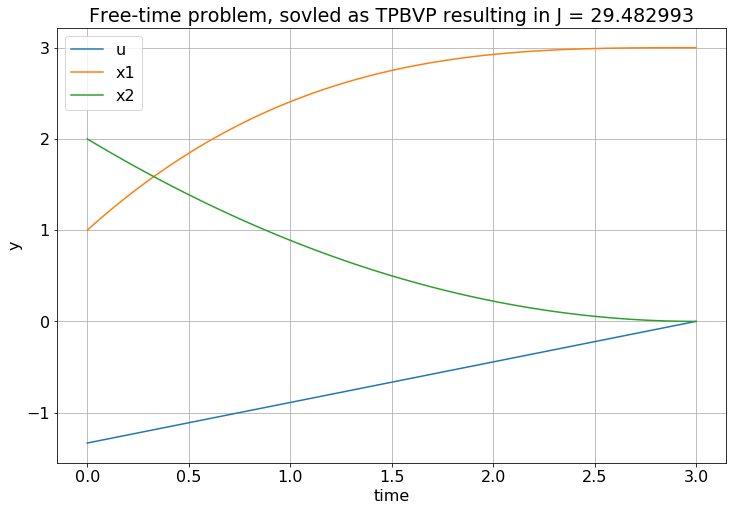

In [35]:
plt.figure(1, figsize=(12,8))
plt.title(f"Free-time problem, sovled as TPBVP resulting in J = {j_star:2.6f}")
plt.plot(times, ustar, label="u")
plt.plot(times, x1_star, label="x1")
plt.plot(times, x2_star, label="x2")
plt.xlabel("time")
plt.ylabel("y")
plt.legend()
plt.grid(which="both")
plt.show()